<a href="https://colab.research.google.com/github/MaroonBlue/Speech_Commands_with_RNNs/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

## Cloning repository

In [8]:
%cd /content/
!rm -r ./Speech_Commands_with_RNNs/
!git clone https://github.com/MaroonBlue/Speech_Commands_with_RNNs.git
%cd Speech_Commands_with_RNNs/

/content
Cloning into 'Speech_Commands_with_RNNs'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 232 (delta 8), reused 18 (delta 7), pack-reused 213
Receiving objects: 100% (232/232), 1.31 MiB | 17.21 MiB/s, done.
Resolving deltas: 100% (129/129), done.
/content/Speech_Commands_with_RNNs


## Installing packages

In [9]:
!pip install -r requirements.txt
!pip install -U -q tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Downloading dataset

## Download form URL

In [14]:
!python utils/download_dataset.py

2023-04-23 12:06:21.444092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 12:06:22.559667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
1121103842/1121103842 [==============================] - 30s 0us/step
Validation files:   0% 0/6798 [00:00<?, ?it/s]
Moved 0 files to the validation directory
Test files:   0% 0/6835 [00:00<?, ?it/s]
Moved 0 files to the test directory


## Generate and save training and validation data

In [11]:
!python ./utils/dataset.py

2023-04-23 13:34:11.040159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Training dataset: 100% 22536/22536 [04:50<00:00, 77.56it/s]
Validation dataset: 100% 6798/6798 [01:11<00:00, 94.52it/s] 


## Copy .npy files to drive

In [22]:
from google.colab import drive
drive.mount('/content/drive/')
!cp -R saved_data ../drive/MyDrive/project_data

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Copy from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/project_data')
!cp -R ../content/drive/project_data saved_data

## Copy from local

In [ ]:
!cp -R data ../data

In [10]:
!cp -R ../data data

# Experiments

## Setup and imports

In [12]:
!wandb online

W&B online. Running your script from this directory will now sync to the cloud.


In [15]:
import os
import wandb
import tensorflow as tf
import sys
import numpy as np

from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from numpy import load

sys.path.append("./")
from utils.utils import set_seeds, make_configs, step_decay
from models.test_model import get_test_model

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

## Configs and data

In [19]:
ENTITY = 'wo-team'
PROJECT = 'dl-rnn-audio'
GROUP = 'test'
NAME = 'test_rnn'
SAVE_PATH = 'weights/'

models = {
    'TestLSTM': get_test_model,
}

base_config = {
    'dataloader': {
        'sample_rate': 8000,
        'unknown_silence_samples': 2000,
        'seed': 0,
        'batch_size': 128,
        'convert_to_image': False,
    },
    'training': {
        'n_epochs': 50,
        'dropout': 0.3,
    },
    'compile':{
        'loss': 'sparse_categorical_crossentropy',
        'optimizer': 'adam',
        'metrics': ['accuracy', 'sparse_categorical_accuracy']
    },
    'model': {
        'architecture': 'TestLSTM',
        'model_init': None,
        'id': None,
        'save_path': None,
    },
    'early_stopper':{
        'monitor': 'val_sparse_categorical_accuracy',
        'min_delta': 0.001,
        'patience': 4,
        'verbose': 1,
        'start_from_epoch': 10,
        'restore_best_weights': True,
    },
    'checkpointer':{
        'monitor': 'val_sparse_categorical_accuracy',
        "verbose": 1,
        'save_best_only': True
    },
    'scheduler': LearningRateScheduler(step_decay),
    'other':{
            'num_classes':12,
    }
}

combinations = {
    'seeds': {
        'dict_path': ['dataloader', 'seed'],
        'values': [0, 1, 2, 3, 4]
    },
}



configs = make_configs(base_config, combinations)

LOAD_PTH = ".\\saved_data\\"
X_t = load(LOAD_PTH + "X_t.npy")
y_t = load(LOAD_PTH + "y_t.npy")
X_v = load(LOAD_PTH + "X_v.npy")
y_v = load(LOAD_PTH + "y_v.npy")
y_t = np.argmax(y_t, axis=1).transpose()
y_v = np.argmax(y_v, axis=1).transpose()

## Training

In [ ]:
start_config = int(input("Provide ID of first config: "))

for i, config in enumerate(configs):
    if i < start_config:
        continue

    set_seeds(config['dataloader']['seed'])
    config['model']['id'] = i
    NAME = config['model']['architecture'] + str(config['model']['id'])
    config['model']['model_init'] = models[config['model']['architecture']]

    wandb.init(
        project = PROJECT,
        entity = ENTITY,
        group = GROUP,
        name = NAME,
        config = config)
    
    l = len(configs)
    print(f"---------------\nConfig {i+1}/{l}\n---------------\n\n")
    print('Running config:', config, "\n")

    input_shape = X_t.shape[1:]

    model = get_test_model(input_shape=input_shape)

    model.compile(**config["compile"])
    earlystopper = EarlyStopping(**config["early_stopper"])
    checkpointer = ModelCheckpoint(NAME+'.h5', **config["checkpointer"])
    lrate = config["scheduler"]


    history = model.fit(
                X_t,
                y_t,
                epochs=config['training']['n_epochs'],
                validation_data=(X_v, y_v),
                batch_size=config['dataloader']['batch_size'],
                shuffle=True,
                callbacks=[
                    earlystopper, 
                    checkpointer, 
                    lrate,
                    WandbMetricsLogger(log_freq=5),
                    WandbModelCheckpoint("weights/wandb")
                ])
    save_path = os.path.join(SAVE_PATH, NAME)
    model.save(save_path)

    wandb.finish()
    !clear

Provide ID of first config: 0


batch/accuracy,▁▂▃▃▃▄▄▄▄▄▄▅▇▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▆▆▅▅▅▅▅▄▂▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/sparse_categorical_accuracy,▁▂▃▃▃▄▄▄▄▄▄▅▇▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch/accuracy,▁▆█
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▃▁
epoch/lr,▁▁▁
epoch/sparse_categorical_accuracy,▁▆█


---------------
Config 1/5
---------------


Running config: {'dataloader': {'sample_rate': 8000, 'unknown_silence_samples': 2000, 'seed': 0, 'batch_size': 128, 'convert_to_image': False}, 'training': {'n_epochs': 50, 'dropout': 0.3}, 'compile': {'loss': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy', 'sparse_categorical_accuracy']}, 'model': {'architecture': 'TestLSTM', 'model_init': <function get_test_model at 0x7f1e5397cc10>, 'id': 0, 'save_path': None}, 'early_stopper': {'monitor': 'val_sparse_categorical_accuracy', 'min_delta': 0.001, 'patience': 4, 'verbose': 1, 'start_from_epoch': 10, 'restore_best_weights': True}, 'checkpointer': {'monitor': 'val_sparse_categorical_accuracy', 'verbose': 1, 'save_best_only': True}, 'scheduler': <keras.callbacks.LearningRateScheduler object at 0x7f1d3936f430>, 'other': {'num_classes': 12}} 

Changing learning rate to 0.001
Epoch 1/50
160/160 [==============================] - ETA: 0s - loss: 1.4525 - accuracy: 0.49

wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 40s 195ms/step - loss: 1.4525 - accuracy: 0.4990 - sparse_categorical_accuracy: 0.4990 - val_loss: 1.8233 - val_accuracy: 0.3762 - val_sparse_categorical_accuracy: 0.3762 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.8412 - accuracy: 0.7392 - sparse_categorical_accuracy: 0.7392
Epoch 2: val_sparse_categorical_accuracy improved from 0.37624 to 0.53202, saving model to TestLSTM0.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 176ms/step - loss: 0.8412 - accuracy: 0.7392 - sparse_categorical_accuracy: 0.7392 - val_loss: 1.3769 - val_accuracy: 0.5320 - val_sparse_categorical_accuracy: 0.5320 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.5961 - accuracy: 0.8150 - sparse_categorical_accuracy: 0.8150
Epoch 3: val_sparse_categorical_accuracy improved from 0.53202 to 0.69301, saving model to TestLSTM0.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 174ms/step - loss: 0.5961 - accuracy: 0.8150 - sparse_categorical_accuracy: 0.8150 - val_loss: 0.9625 - val_accuracy: 0.6930 - val_sparse_categorical_accuracy: 0.6930 - lr: 0.0010
Changing learning rate to 0.001
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.8503 - sparse_categorical_accuracy: 0.8503
Epoch 4: val_sparse_categorical_accuracy improved from 0.69301 to 0.73423, saving model to TestLSTM0.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 175ms/step - loss: 0.4871 - accuracy: 0.8503 - sparse_categorical_accuracy: 0.8503 - val_loss: 0.8137 - val_accuracy: 0.7342 - val_sparse_categorical_accuracy: 0.7342 - lr: 0.0010
Changing learning rate to 0.001
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.4067 - accuracy: 0.8736 - sparse_categorical_accuracy: 0.8736
Epoch 5: val_sparse_categorical_accuracy improved from 0.73423 to 0.80772, saving model to TestLSTM0.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 176ms/step - loss: 0.4067 - accuracy: 0.8736 - sparse_categorical_accuracy: 0.8736 - val_loss: 0.6256 - val_accuracy: 0.8077 - val_sparse_categorical_accuracy: 0.8077 - lr: 0.0010
Changing learning rate to 0.001
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.8924 - sparse_categorical_accuracy: 0.8924
Epoch 6: val_sparse_categorical_accuracy improved from 0.80772 to 0.80838, saving model to TestLSTM0.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 176ms/step - loss: 0.3508 - accuracy: 0.8924 - sparse_categorical_accuracy: 0.8924 - val_loss: 0.6379 - val_accuracy: 0.8084 - val_sparse_categorical_accuracy: 0.8084 - lr: 0.0010
Changing learning rate to 0.001
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.9056 - sparse_categorical_accuracy: 0.9056
Epoch 7: val_sparse_categorical_accuracy improved from 0.80838 to 0.81734, saving model to TestLSTM0.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.2s


160/160 [==============================] - 28s 175ms/step - loss: 0.3074 - accuracy: 0.9056 - sparse_categorical_accuracy: 0.9056 - val_loss: 0.6353 - val_accuracy: 0.8173 - val_sparse_categorical_accuracy: 0.8173 - lr: 0.0010
Changing learning rate to 0.001
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.9119 - sparse_categorical_accuracy: 0.9119
Epoch 8: val_sparse_categorical_accuracy improved from 0.81734 to 0.83347, saving model to TestLSTM0.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 177ms/step - loss: 0.2864 - accuracy: 0.9119 - sparse_categorical_accuracy: 0.9119 - val_loss: 0.5488 - val_accuracy: 0.8335 - val_sparse_categorical_accuracy: 0.8335 - lr: 0.0010
Changing learning rate to 0.001
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9263 - sparse_categorical_accuracy: 0.9263
Epoch 9: val_sparse_categorical_accuracy improved from 0.83347 to 0.83803, saving model to TestLSTM0.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 175ms/step - loss: 0.2412 - accuracy: 0.9263 - sparse_categorical_accuracy: 0.9263 - val_loss: 0.5565 - val_accuracy: 0.8380 - val_sparse_categorical_accuracy: 0.8380 - lr: 0.0010
Changing learning rate to 0.0004
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.9536 - sparse_categorical_accuracy: 0.9536
Epoch 10: val_sparse_categorical_accuracy improved from 0.83803 to 0.84341, saving model to TestLSTM0.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.2s


160/160 [==============================] - 28s 174ms/step - loss: 0.1544 - accuracy: 0.9536 - sparse_categorical_accuracy: 0.9536 - val_loss: 0.5708 - val_accuracy: 0.8434 - val_sparse_categorical_accuracy: 0.8434 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9653 - sparse_categorical_accuracy: 0.9653
Epoch 11: val_sparse_categorical_accuracy improved from 0.84341 to 0.85253, saving model to TestLSTM0.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 175ms/step - loss: 0.1166 - accuracy: 0.9653 - sparse_categorical_accuracy: 0.9653 - val_loss: 0.5923 - val_accuracy: 0.8525 - val_sparse_categorical_accuracy: 0.8525 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9696 - sparse_categorical_accuracy: 0.9696
Epoch 12: val_sparse_categorical_accuracy improved from 0.85253 to 0.85710, saving model to TestLSTM0.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.2s


160/160 [==============================] - 28s 175ms/step - loss: 0.0998 - accuracy: 0.9696 - sparse_categorical_accuracy: 0.9696 - val_loss: 0.6118 - val_accuracy: 0.8571 - val_sparse_categorical_accuracy: 0.8571 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9716 - sparse_categorical_accuracy: 0.9716
Epoch 13: val_sparse_categorical_accuracy did not improve from 0.85710


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 26s 162ms/step - loss: 0.0916 - accuracy: 0.9716 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.6772 - val_accuracy: 0.8416 - val_sparse_categorical_accuracy: 0.8416 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9725 - sparse_categorical_accuracy: 0.9725
Epoch 14: val_sparse_categorical_accuracy did not improve from 0.85710


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 176ms/step - loss: 0.0893 - accuracy: 0.9725 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.6716 - val_accuracy: 0.8564 - val_sparse_categorical_accuracy: 0.8564 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9757 - sparse_categorical_accuracy: 0.9757
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.85710


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 174ms/step - loss: 0.0814 - accuracy: 0.9757 - sparse_categorical_accuracy: 0.9757 - val_loss: 0.6488 - val_accuracy: 0.8566 - val_sparse_categorical_accuracy: 0.8566 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9763 - sparse_categorical_accuracy: 0.9763Restoring model weights from the end of the best epoch: 12.

Epoch 16: val_sparse_categorical_accuracy did not improve from 0.85710


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 27s 168ms/step - loss: 0.0793 - accuracy: 0.9763 - sparse_categorical_accuracy: 0.9763 - val_loss: 0.8009 - val_accuracy: 0.8333 - val_sparse_categorical_accuracy: 0.8333 - lr: 4.0000e-04
Epoch 16: early stopping


batch/accuracy,▁▂▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,███████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/sparse_categorical_accuracy,▁▂▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
epoch/accuracy,▁▅▆▆▆▇▇▇▇███████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch/learning_rate,█████████▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch/lr,█████████▁▁▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▅▆▆▆▇▇▇▇███████


wandb: Currently logged in as: wladeko (wo-team). Use `wandb login --relogin` to force relogin


---------------
Config 2/5
---------------


Running config: {'dataloader': {'sample_rate': 8000, 'unknown_silence_samples': 2000, 'seed': 1, 'batch_size': 128, 'convert_to_image': False}, 'training': {'n_epochs': 50, 'dropout': 0.3}, 'compile': {'loss': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy', 'sparse_categorical_accuracy']}, 'model': {'architecture': 'TestLSTM', 'model_init': <function get_test_model at 0x7f1e5397cc10>, 'id': 1, 'save_path': None}, 'early_stopper': {'monitor': 'val_sparse_categorical_accuracy', 'min_delta': 0.001, 'patience': 4, 'verbose': 1, 'start_from_epoch': 10, 'restore_best_weights': True}, 'checkpointer': {'monitor': 'val_sparse_categorical_accuracy', 'verbose': 1, 'save_best_only': True}, 'scheduler': <keras.callbacks.LearningRateScheduler object at 0x7f1d3936f2e0>, 'other': {'num_classes': 12}} 

Changing learning rate to 0.001
Epoch 1/50
160/160 [==============================] - ETA: 0s - loss: 1.5207 - accuracy: 0.47

wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 40s 198ms/step - loss: 1.5207 - accuracy: 0.4732 - sparse_categorical_accuracy: 0.4732 - val_loss: 1.8989 - val_accuracy: 0.3248 - val_sparse_categorical_accuracy: 0.3248 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.8261 - accuracy: 0.7430 - sparse_categorical_accuracy: 0.7430
Epoch 2: val_sparse_categorical_accuracy improved from 0.32475 to 0.69480, saving model to TestLSTM1.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 177ms/step - loss: 0.8261 - accuracy: 0.7430 - sparse_categorical_accuracy: 0.7430 - val_loss: 0.9298 - val_accuracy: 0.6948 - val_sparse_categorical_accuracy: 0.6948 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/50
158/160 [============================>.] - ETA: 0s - loss: 0.6062 - accuracy: 0.8136 - sparse_categorical_accuracy: 0.8136

# Debug

## 1

In [ ]:
from keras import Sequential
from keras.layers import SimpleRNN, Dropout, Dense, Activation, BatchNormalization

model2 = Sequential()
model2.add(BatchNormalization())
model2.add(SimpleRNN(
    128,
    input_shape=(8000,),
    return_sequences=True
))
model2.add(Dropout(0.5))
model2.add(SimpleRNN(128, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(SimpleRNN(256))
model2.add(Dense(256))
model2.add(Dropout(0.5))
model2.add(Dense(12))
model2.add(Activation('softmax'))

In [ ]:
import os
from os.path import isdir, join

import numpy as np
import pandas as pd
import tensorflow as tf

import random
import librosa

from sklearn.utils import shuffle

config = {
    'dataloader': {
        'sample_rate': 8000,
        'unknown_silence_samples': 2000,
        'seed': 0,
        'batch_size': 128,
        'convert_to_image': False,
    },
    'training': {
        'n_epochs': 50,
        'dropout': 0.3,
    },
    'compile':{
        'loss': 'sparse_categorical_crossentropy',
        'optimizer': 'adam',
        'metrics': ['accuracy', 'sparse_categorical_accuracy']
    },
    'model': {
        'architecture': 'TestGRU',
        'id': None,
        'save_path': None,
    },
    'early_stopper':{
        'monitor': 'val_sparse_categorical_accuracy',
        'min_delta': 0.001,
        'patience': 4,
        'verbose': 1,
        'start_from_epoch': 10,
        'restore_best_weights': True,
    },
    'checkpointer':{
        'monitor': 'val_sparse_categorical_accuracy',
        "verbose": 1,
        'save_best_only': True
    },
    # 'scheduler': LearningRateScheduler(step_decay),
    'other':{
            'num_classes':12,
    }
}

combinations = {
    'seeds': {
        'dict_path': ['dataloader', 'seed'],
        'values': [0, 1, 2, 3, 4]
    },
}

def audio2mel(path):
    y, sr = librosa.core.load(path=path)
    if len(y) > sr: # we set all to have lenght equal to 1 second 
        y = y[:sr] 
    else: # pad blank
        padding = sr - len(y)
        offset = padding // 2 
        y = np.pad(y, (offset, sr - len(y) - offset), 'constant')
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    return librosa.power_to_db(mel, ref= np.max).astype(np.float).transpose()

def make_train_dataset(path='./data/train/audio/', sample_rate=8000, unknown_silence_samples = 2000, seed=0, batch_size=128, convert_to_image=False):
    train_audio_path = path
    dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
    dirs.sort()
    
    known_wav = []
    unknown_wav = []
    known_label = []
    target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
    unknown_list = [d for d in dirs if d not in target_list and d != '_background_noise_' ]

    background = [f for f in os.listdir(join(train_audio_path, '_background_noise_')) if f.endswith('.wav')]
    background_wav = []
    for wav in background : 
        wav_pth = os.path.join(train_audio_path, '_background_noise_', wav)
        background_wav.append(wav_pth)

    for direct in dirs[1:]:
        waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
        for wav in waves:
            wav_pth = os.path.join(train_audio_path, direct, wav)
            if direct in unknown_list:
                unknown_wav.append(wav_pth)
            else:
                known_wav.append(wav_pth)
                known_label.append(direct)

    unknown_sample_wav = random.sample(unknown_wav, k=unknown_silence_samples)

    silence_sample_wav = []
    num_wav = (unknown_silence_samples)//len(background_wav)
    for i in background_wav:
        for _ in range(num_wav):
            silence_sample_wav.append(i)
    random.shuffle(silence_sample_wav)

    unknown_sample_label = ['unknown' for _ in range(len(unknown_sample_wav))]
    silence_sample_label = ['silence' for _ in range(len(silence_sample_wav))]

    selected_wav = known_wav + unknown_sample_wav + silence_sample_wav
    selected_label = known_label + unknown_sample_label + silence_sample_label

    selected_loaded = []
    to_delete = []
    for i, wav in enumerate(selected_wav):
        samples, sr = librosa.load(wav, sr = sample_rate)
        if sr != sample_rate:
            samples = librosa.resample(samples, orig_sr=sr, target_sr=sample_rate)
        if selected_label[i] == 'silence':
            start_idx = random.randint(0, len(samples)- 1 - sample_rate)
            samples = samples[start_idx:(start_idx + sample_rate)]
        if len(samples) != sample_rate:
            to_delete.append(i)
            continue
        else:
            samples = librosa.feature.melspectrogram(y=samples, sr=sample_rate, fmin=20.0, fmax=sample_rate / 2, hop_length=100)
            samples = librosa.power_to_db(samples, ref=np.max).astype(np.float64).transpose()
        selected_loaded.append(samples)

    selected_label = [j for i, j in enumerate(selected_label) if i not in to_delete]

    selected_loaded = np.array(selected_loaded)

    label_value = target_list
    label_value.append('unknown')
    label_value.append('silence')
    new_label_value = dict()
    for i, l in enumerate(label_value):
        new_label_value[l] = i
    label_value = new_label_value
    temp = []
    for l in selected_label:
        temp.append(label_value[l])
    selected_label = np.array(temp).reshape(-1,1)

    if convert_to_image:
        selected_loaded = convert_wav_to_image(pd.dataframe(selected_loaded))

    # selected_label = tf.keras.utils.to_categorical(selected_label, num_classes = 12)
    X, y = shuffle(selected_loaded, selected_label)

    # dataset = tf.data.Dataset.from_tensor_slices((selected_loaded, selected_label)).shuffle(buffer_size=len(selected_label), seed=seed, reshuffle_each_iteration=False).batch(batch_size=batch_size)
    return X, y

X, y = make_train_dataset(**config['dataloader'])

In [ ]:
def make_val_dataset(path='./data/val/audio/', unknown_silence_samples = 2000, sample_rate=8000, convert_to_image=False, seed=0, batch_size=128):
    train_audio_path = path
    dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
    dirs.sort()
    
    known_wav = []
    unknown_wav = []
    known_label = []
    target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
    unknown_list = [d for d in dirs if d not in target_list and d != '_background_noise_' ]

    for direct in dirs:
        waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
        for wav in waves:
            wav_pth = os.path.join(train_audio_path, direct, wav, wav)
            if direct in unknown_list:
                unknown_wav.append(wav_pth)
            else:
                known_wav.append(wav_pth)
                known_label.append(direct)

    unknown_label = ['unknown' for _ in range(len(unknown_wav))]
    

    all_wav = known_wav + unknown_wav
    all_label = known_label + unknown_label

    all_loaded = []
    to_delete = []
    for i, wav in enumerate(all_wav):
        samples, sr = librosa.load(wav, sr = sample_rate)
        if sr != sample_rate:
            samples = librosa.resample(samples, sr, sample_rate)
        if len(samples) != sample_rate:
            to_delete.append(i)
            continue
        else:
            samples = librosa.feature.melspectrogram(y=samples, sr=sample_rate, fmin=20.0, fmax=sample_rate / 2, hop_length=100)
            samples = librosa.power_to_db(samples, ref=np.max).astype(np.float64).transpose()
        all_loaded.append(samples)
        
    all_label = [j for i, j in enumerate(all_label) if i not in to_delete]

    all_loaded = np.stack(all_loaded, axis=0)

    label_value = target_list
    label_value.append('unknown')
    label_value.append('silence')
    new_label_value = dict()
    for i, l in enumerate(label_value):
        new_label_value[l] = i
    label_value = new_label_value
    temp = []
    for l in all_label:
        temp.append(label_value[l])
    all_label = np.array(temp).reshape(-1,1)

    if convert_to_image:
        all_loaded = convert_wav_to_image(pd.dataframe(all_loaded))

    # all_label = tf.keras.utils.to_categorical(all_label, num_classes = 12)
    X, y = shuffle(all_loaded, all_label)
    # dataset = tf.data.Dataset.from_tensor_slices((all_loaded, all_label)).shuffle(buffer_size=len(all_label), seed=seed, reshuffle_each_iteration=True).batch(batch_size=batch_size)
    return X, y

X, y = make_val_dataset(**config['dataloader'])

## 2

In [ ]:
lengths = [len(i) for i in X] 

In [ ]:
print(lengths)

[81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,

In [ ]:
lengths.sort()
print(lengths)

[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 800

In [ ]:
X_t.shape

(20413, 81, 128)

In [ ]:
y_t.shape

(20413, 1)

In [ ]:
X_t.shape[1:]

(81, 128)

In [ ]:
import matplotlib.pyplot as plt


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

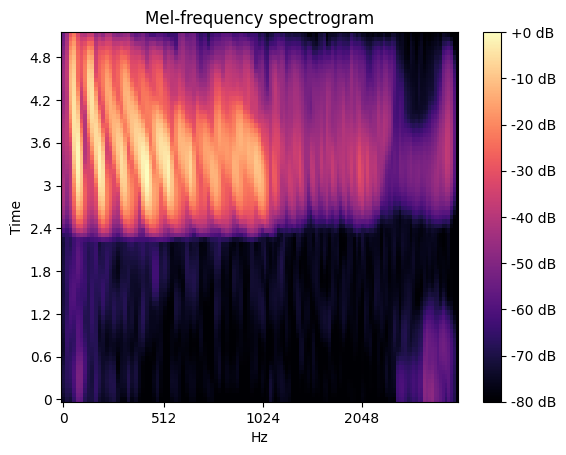

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(X[5], x_axis='mel',
                         y_axis='time', sr=8000,
                         ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
X[0].shape

(81, 128)

In [ ]:
y[5]

array([6])